### Finding Cut-off Temperatures for Controlling and decision making


This short script looks for the temperature at which the heat pump is to be turned off in every cycle, depending on the nominal power. Therefore we optimize one cycle for every nominal power between 3 and 4kW, with the condition, that the starting temperature must be equal to the ending temperature. Note that the higher powers don't manage to fulfill this constraint and ouput "None".

In [59]:

import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

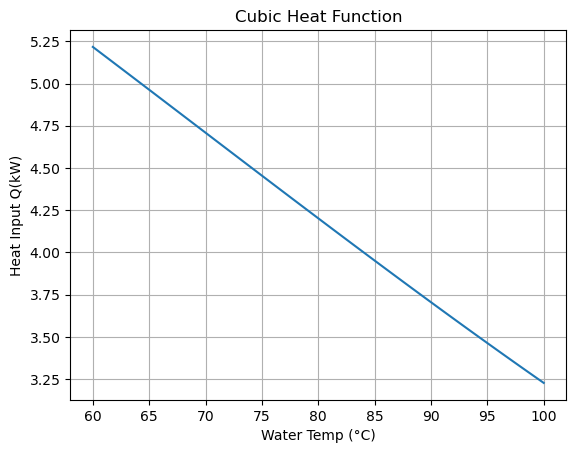

In [60]:
import numpy as np
import matplotlib.pyplot as plt

a, b, c, d = heat_coeffs
T = np.linspace(60, 100, 100)
Q = a*T**3 + b*T**2 + c*T + d

plt.plot(T, Q)
plt.xlabel("Water Temp (°C)")
plt.ylabel("Heat Input Q(kW)")
plt.title("Cubic Heat Function")
plt.grid(True)
plt.show()


Set parameter OutputFlag to value 1
Set parameter NonConvex to value 2
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 21.6.0 21H1320)

CPU model: Intel(R) Core(TM) i5-6267U CPU @ 2.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Non-default parameters:
NonConvex  2

Optimize a model with 3606 rows, 4326 columns and 7327 nonzeros
Model fingerprint: 0x98c0326f
Model has 2163 quadratic constraints
Variable types: 3605 continuous, 721 integer (721 binary)
Coefficient statistics:
  Matrix range     [6e-04, 1e+00]
  QMatrix range    [1e-06, 1e+00]
  QLMatrix range   [1e+00, 8e+00]
  Objective range  [3e-04, 3e-04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-03, 9e+01]
Presolve removed 2608 rows and 2249 columns
Presolve time: 2.84s
Presolved: 5268 rows, 2078 columns, 15571 nonzeros
Presolved model has 1220 bilinear constraint(s)

Solving non-convex MIQCP

Variable types: 2007 continuous, 71 integer (71 binary)

Root simpl

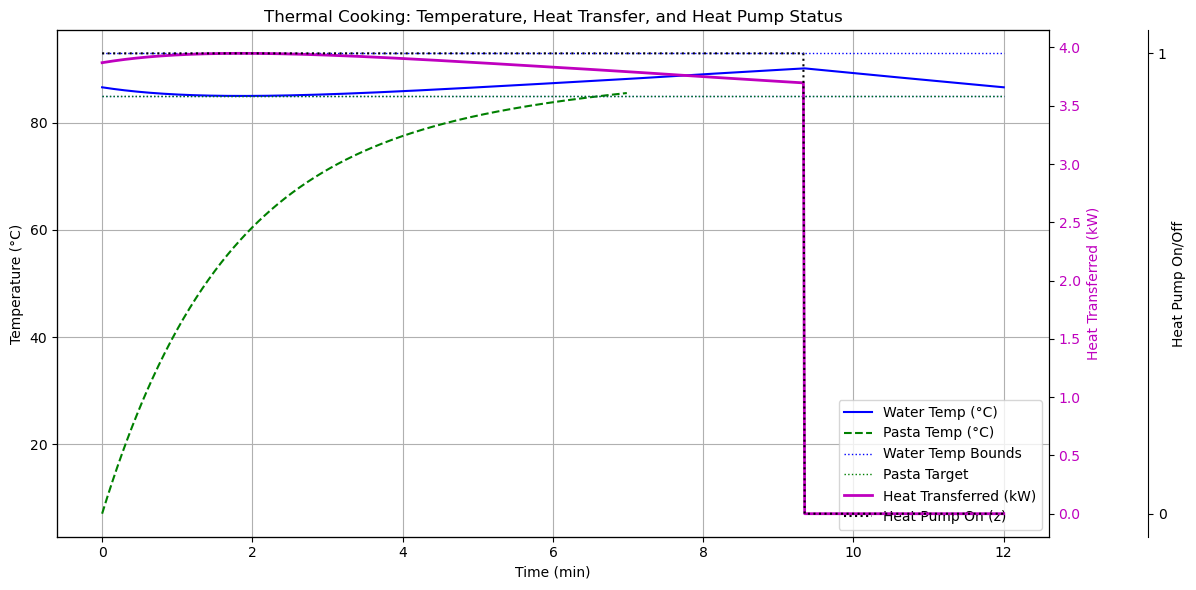

In [61]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

# --- Heat polynomial coefficients: Q(T) = a*T^3 + b*T^2 + c*T + d ---
heat_coeffs = [1.49214e-06, -0.000307792, -0.0297413, 7.78723]  # Example coefficients

# --- Time and Cooking Parameters ---
dt = 1  # seconds
cook_time = 7 * 60  # 7 minutes
cool_time = 5 * 60  # 5 minutes
total_time = cook_time + cool_time
n_steps = total_time + 1  # time steps

# --- Environment and Physical Properties ---
T_env = 20  # Celsius
T_pasta_0 = 7  # Initial pasta temp
R_env = 30 / 1000  # K/W
R_pasta = 15 / 1000  # K/W
c_l = 4.18 * 1000  # J/kg/K
c_pasta = 3.5 * 1000  # J/kg/K

# Geometry for water volume
V_water = (47 - 0.4) * (27 - 0.4) * (20 - 0.2) / 1e6  # m^3
m_water = V_water * 1000  # kg
m_pasta = 2  # kg

C_water = m_water * c_l  # J/K
C_pasta = m_pasta * c_pasta  # J/K

# --- Gurobi Model ---
model = gp.Model("Thermal_Cooking_Optimized")
model.setParam("OutputFlag", 1)
model.setParam("NonConvex", 2)

# --- Variables ---
z = model.addVars(n_steps, vtype=GRB.BINARY, name="z")  # Heat on/off
Q = model.addVars(n_steps, lb=0, name="Q")  # Heat input in kW
T_water = model.addVars(n_steps, lb=0, name="T_water")
T_pasta = model.addVars(n_steps, lb=0, name="T_pasta")

# --- Initial Conditions ---

model.addConstr(T_pasta[0] == T_pasta_0)

# --- Heat only once per cycle (once turned off, stays off) ---
for t in range(1, n_steps):
    model.addConstr(z[t] <= z[t - 1], name=f"z_switch_{t}")

# --- Heat input polynomial Q(T) in kW, activate only when z[t]=1 ---
for t in range(n_steps):
    T = T_water[t]
    T_sq = model.addVar(lb=0, name=f"T_sq_{t}")
    T_cu = model.addVar(lb=0, name=f"T_cu_{t}")

    model.addConstr(T_sq == T * T)
    model.addConstr(T_cu == T_sq * T)

    # Polynomial heat input in kW * 1000 = W
    model.addConstr(
        Q[t] == (heat_coeffs[0] * T_cu + heat_coeffs[1] * T_sq + heat_coeffs[2] * T + heat_coeffs[3]) * z[t]
    )

# --- System Dynamics ---
for t in range(1, n_steps):
    if t <= cook_time:
        model.addConstr(
            T_water[t] == T_water[t - 1] + dt * (Q[t - 1] * 1000 - (T_water[t - 1] - T_env) / R_env - (T_water[t - 1] - T_pasta[t - 1]) / R_pasta) / C_water
        )
        model.addConstr(
            T_pasta[t] == T_pasta[t - 1] + dt * ((T_water[t - 1] - T_pasta[t - 1]) / R_pasta) / C_pasta
        )
    else:
        model.addConstr(
            T_water[t] == T_water[t - 1] + dt * (Q[t - 1] * 1000 - (T_water[t - 1] - T_env) / R_env) / C_water
        )
        model.addConstr(T_pasta[t] == T_pasta[t - 1])

# --- Temperature constraints ---
for t in range(n_steps):
    model.addConstr(T_water[t] >= 85)
    model.addConstr(T_water[t] <= 93)

# --- Pasta must be ready at end of cooking period ---
model.addConstr(T_pasta[cook_time] >= 85)
model.addConstr(T_pasta[cook_time] <= 86)
model.addConstr(T_water[0] == T_water[cook_time + n_cool])  # Water temp at start and end of cooking must match

# --- Objective: minimize total heating energy in kWh ---
total_energy = gp.quicksum(Q[t] * dt / 3600 for t in range(n_steps))  # kWh
model.setObjective(total_energy, GRB.MINIMIZE)

# --- Optimize ---
model.optimize()

# --- Extract and Plot Results ---
if model.status == GRB.OPTIMAL:
    # --- Time vector in minutes ---
    t_minutes = np.arange(n_total) / 60

    # --- Extract decision variable results from Gurobi solution ---
    T_water_vals = np.array([T_water[i].X for i in range(n_total)])
    T_pasta_vals = np.array([T_pasta[i].X for i in range(n_total)])
    Q_vals = np.array([Q[i].X for i in range(n_total)])
    z_vals = np.array([z[i].X for i in range(n_total)])

    # --- Heat transferred (in kW) based on cubic function of T_water ---
    a, b, c, d = heat_coeffs
    Q_actual_vals = a * T_water_vals**3 + b * T_water_vals**2 + c * T_water_vals + d

    # --- Plot setup ---
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # -- Axis 1: Temperature (°C)
    ax1.plot(t_minutes, T_water_vals, 'b-', label='Water Temp (°C)')
    ax1.plot(t_minutes[:7*60], T_pasta_vals[:7*60], 'g--', label='Pasta Temp (°C)')
    ax1.hlines([85, 93], 0, t_minutes[-1], colors='b', linestyles='dotted', linewidth=1, label='Water Temp Bounds')
    ax1.hlines(85, 0, t_minutes[-1], colors='g', linestyles='dotted', linewidth=1, label='Pasta Target')
    ax1.set_xlabel("Time (min)")
    ax1.set_ylabel("Temperature (°C)", color='k')
    ax1.tick_params(axis='y', labelcolor='k')
    ax1.grid(True)

    # -- Axis 2: Heat transferred (kW)
    ax2 = ax1.twinx()
    ax2.plot(t_minutes, Q_actual_vals*z_vals, 'm-', linewidth=2, label='Heat Transferred (kW)')
    ax2.set_ylabel("Heat Transferred (kW)", color='m')
    ax2.tick_params(axis='y', labelcolor='m')

    # -- Axis 3: Heat pump status (binary) as stepped line
    ax3 = ax1.twinx()
    ax3.spines["right"].set_position(("axes", 1.1))  # offset third axis
    ax3.plot(t_minutes, z_vals, 'k:', linewidth=1.5, label='Heat Pump On (z)')
    ax3.set_ylabel("Heat Pump On/Off", color='k')
    ax3.tick_params(axis='y', labelcolor='k')
    ax3.set_yticks([0, 1])

    # Combine all legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    ax1.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, loc='lower right')

    plt.title("Thermal Cooking: Temperature, Heat Transfer, and Heat Pump Status")
    plt.tight_layout()
    plt.show()


else:
    print("❌ No feasible or optimal solution found.")


In [62]:
#print the pasta temperature at the end of cooking
if model.status == GRB.OPTIMAL:
    print(f"Final Pasta Temperature: {T_pasta[n_cook].X:.2f} °C")
else:
    print("Model did not find an optimal solution.")

Final Pasta Temperature: 85.61 °C
